# Neural Network mit minimalem Datensatz (100 Samples) - PyTorch
## Analyse: Overfitting vs. Underfitting

Ziel: Trainiere ein neuronales Netzwerk mit nur ~100 Samples und analysiere, ob die Predictions Overfitting oder Underfitting zeigen.

In [388]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

# Setze Random Seeds für Reproduzierbarkeit
np.random.seed(42)
torch.manual_seed(42)

# Device konfigurieren (GPU falls verfügbar)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch Version: {torch.__version__}")

Using device: cpu
PyTorch Version: 2.9.1


## 1. Daten laden und auf 100 Samples reduzieren

In [389]:
# Lade den kompletten Datensatz
BASE_DIR = Path.cwd().parent
DATA_PATH = BASE_DIR / "housing.csv"

df_full = pd.read_csv(DATA_PATH)
print(f"Kompletter Datensatz: {len(df_full)} Zeilen")

# Reduziere auf 100 Samples (stratifiziert nach Preis-Quartilen)
# Damit haben wir eine repräsentative Verteilung
df_full['price_quartile'] = pd.qcut(df_full['median_house_value'], q=4, labels=False)
df_small = df_full.groupby('price_quartile', group_keys=False).apply(
    lambda x: x.sample(n=25, random_state=42)
).drop('price_quartile', axis=1).reset_index(drop=True)

print(f"\nReduzierter Datensatz: {len(df_small)} Zeilen")
print(f"\nPreisverteilung (original):")
print(df_full['median_house_value'].describe())
print(f"\nPreisverteilung (reduziert):")
print(df_small['median_house_value'].describe())

Kompletter Datensatz: 20640 Zeilen

Reduzierter Datensatz: 100 Zeilen

Preisverteilung (original):
count     20640.000000
mean     206855.816909
std      115395.615874
min       14999.000000
25%      119600.000000
50%      179700.000000
75%      264725.000000
max      500001.000000
Name: median_house_value, dtype: float64

Preisverteilung (reduziert):
count       100.000000
mean     200984.040000
std      114071.892382
min       45500.000000
25%      119725.000000
50%      177750.000000
75%      266400.000000
max      500001.000000
Name: median_house_value, dtype: float64


## 2. Feature Engineering

In [390]:
def engineer_features(df):
    """Erstelle zusätzliche Features"""
    df = df.copy()
    
    # Verhindere Division durch Null
    df['households'] = df['households'].replace(0, np.nan)
    df['total_rooms'] = df['total_rooms'].replace(0, np.nan)
    
    # Feature Engineering
    df['rooms_per_household'] = df['total_rooms'] / df['households']
    df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
    df['population_per_household'] = df['population'] / df['households']
    
    return df

df_small = engineer_features(df_small)

# One-Hot Encoding für ocean_proximity
df_small = pd.get_dummies(df_small, columns=['ocean_proximity'], drop_first=False)

print("Features nach Engineering:")
print(df_small.columns.tolist())
print(f"\nAnzahl Features: {len(df_small.columns) - 1}")

Features nach Engineering:
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'rooms_per_household', 'bedrooms_per_room', 'population_per_household', 'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']

Anzahl Features: 15


## 3. Daten vorbereiten

In [391]:
# Trenne Features und Target
X = df_small.drop('median_house_value', axis=1)
y = df_small['median_house_value']

# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training Set: {len(X_train)} Samples")
print(f"Test Set: {len(X_test)} Samples")

# Impute fehlende Werte
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Standardisierung
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Target auch skalieren für besseres NN Training
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Konvertiere zu PyTorch Tensoren
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test_scaled).to(device)

print(f"\nInput Shape: {X_train_tensor.shape}")
print(f"Anzahl Features: {X_train_tensor.shape[1]}")

Training Set: 80 Samples
Test Set: 20 Samples

Input Shape: torch.Size([80, 15])
Anzahl Features: 15


## 4. Neural Network Modelle definieren (PyTorch)

Wir verwenden ein relativ großes Netzwerk für nur 80 Trainingssamples, um Overfitting zu provozieren.

In [392]:
class SmallNet(nn.Module):
    """Kleines Netzwerk (weniger Parameter als Trainingssamples)"""
    def __init__(self, input_dim):
        super(SmallNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class MediumNet(nn.Module):
    """Mittleres Netzwerk"""
    def __init__(self, input_dim):
        super(MediumNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class LargeNet(nn.Module):
    """Großes Netzwerk (viele Parameter für wenig Daten -> Overfitting)"""
    def __init__(self, input_dim):
        super(LargeNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Erstelle Modelle
input_dim = X_train_tensor.shape[1]

model_small = SmallNet(input_dim).to(device)
model_medium = MediumNet(input_dim).to(device)
model_large = LargeNet(input_dim).to(device)

# Zeige Modellarchitekturen
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("=" * 60)
print("SMALL MODEL")
print("=" * 60)
print(model_small)
print(f"Trainierbare Parameter: {count_parameters(model_small):,}")

print("\n" + "=" * 60)
print("MEDIUM MODEL")
print("=" * 60)
print(model_medium)
print(f"Trainierbare Parameter: {count_parameters(model_medium):,}")

print("\n" + "=" * 60)
print("LARGE MODEL")
print("=" * 60)
print(model_large)
print(f"Trainierbare Parameter: {count_parameters(model_large):,}")

print(f"\n{'='*60}")
print(f"Trainingssamples: {len(X_train)}")
print(f"{'='*60}")

SMALL MODEL
SmallNet(
  (fc1): Linear(in_features=15, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)
Trainierbare Parameter: 1,057

MEDIUM MODEL
MediumNet(
  (fc1): Linear(in_features=15, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)
Trainierbare Parameter: 3,649

LARGE MODEL
LargeNet(
  (fc1): Linear(in_features=15, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)
Trainierbare Parameter: 12,929

Trainingssamples: 80


## 5. Training-Funktion

In [393]:
def train_model(model, X_train, y_train, X_test, y_test, epochs=500, batch_size=16, lr=0.001):
    """Trainiere ein PyTorch Modell und tracke Training/Validation Loss"""
    
    # Loss und Optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # DataLoader für Mini-Batch Training
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Tracking
    history = {
        'train_loss': [],
        'val_loss': []
    }
    
    # Training Loop
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        
        for batch_X, batch_y in train_loader:
            # Forward pass
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
        
        # Durchschnittlicher Training Loss
        avg_train_loss = np.mean(train_losses)
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test).squeeze()
            val_loss = criterion(val_outputs, y_test).item()
        
        # Speichere History
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(val_loss)
        
        # Ausgabe alle 100 Epochen
        if (epoch + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    return history

## 6. Trainiere die Modelle

In [394]:
# Training mit vielen Epochen, um Overfitting zu sehen
epochs = 500
batch_size = 16
learning_rate = 0.001

print("Training SMALL Model...")
print("=" * 60)
history_small = train_model(model_small, X_train_tensor, y_train_tensor, 
                            X_test_tensor, y_test_tensor, epochs, batch_size, learning_rate)
print("✓ Small Model fertig\n")

print("Training MEDIUM Model...")
print("=" * 60)
history_medium = train_model(model_medium, X_train_tensor, y_train_tensor, 
                             X_test_tensor, y_test_tensor, epochs, batch_size, learning_rate)
print("✓ Medium Model fertig\n")

print("Training LARGE Model...")
print("=" * 60)
history_large = train_model(model_large, X_train_tensor, y_train_tensor, 
                            X_test_tensor, y_test_tensor, epochs, batch_size, learning_rate)
print("✓ Large Model fertig\n")

print("\n" + "=" * 60)
print("Alle Modelle trainiert!")
print("=" * 60)

Training SMALL Model...
Epoch [100/500] - Train Loss: 0.0913, Val Loss: 0.2579
Epoch [200/500] - Train Loss: 0.0208, Val Loss: 0.2129
Epoch [300/500] - Train Loss: 0.0058, Val Loss: 0.2157
Epoch [400/500] - Train Loss: 0.0025, Val Loss: 0.2483
Epoch [500/500] - Train Loss: 0.0006, Val Loss: 0.2849
✓ Small Model fertig

Training MEDIUM Model...
Epoch [100/500] - Train Loss: 0.0177, Val Loss: 0.3432
Epoch [200/500] - Train Loss: 0.0009, Val Loss: 0.3466
Epoch [300/500] - Train Loss: 0.0011, Val Loss: 0.3612
Epoch [400/500] - Train Loss: 0.0048, Val Loss: 0.3636
Epoch [500/500] - Train Loss: 0.0000, Val Loss: 0.3613
✓ Medium Model fertig

Training LARGE Model...
Epoch [100/500] - Train Loss: 0.0069, Val Loss: 0.2594
Epoch [200/500] - Train Loss: 0.0008, Val Loss: 0.2988
Epoch [300/500] - Train Loss: 0.0000, Val Loss: 0.3140
Epoch [400/500] - Train Loss: 0.0051, Val Loss: 0.3509
Epoch [500/500] - Train Loss: 0.0003, Val Loss: 0.3312
✓ Large Model fertig


Alle Modelle trainiert!


## 7. Visualisierung: Training vs. Validation Loss

**Interpretation:**
- **Underfitting**: Beide Losses sind hoch und konvergieren nicht
- **Good Fit**: Beide Losses sind niedrig und nah beieinander
- **Overfitting**: Training Loss ist sehr niedrig, aber Validation Loss ist hoch oder steigt

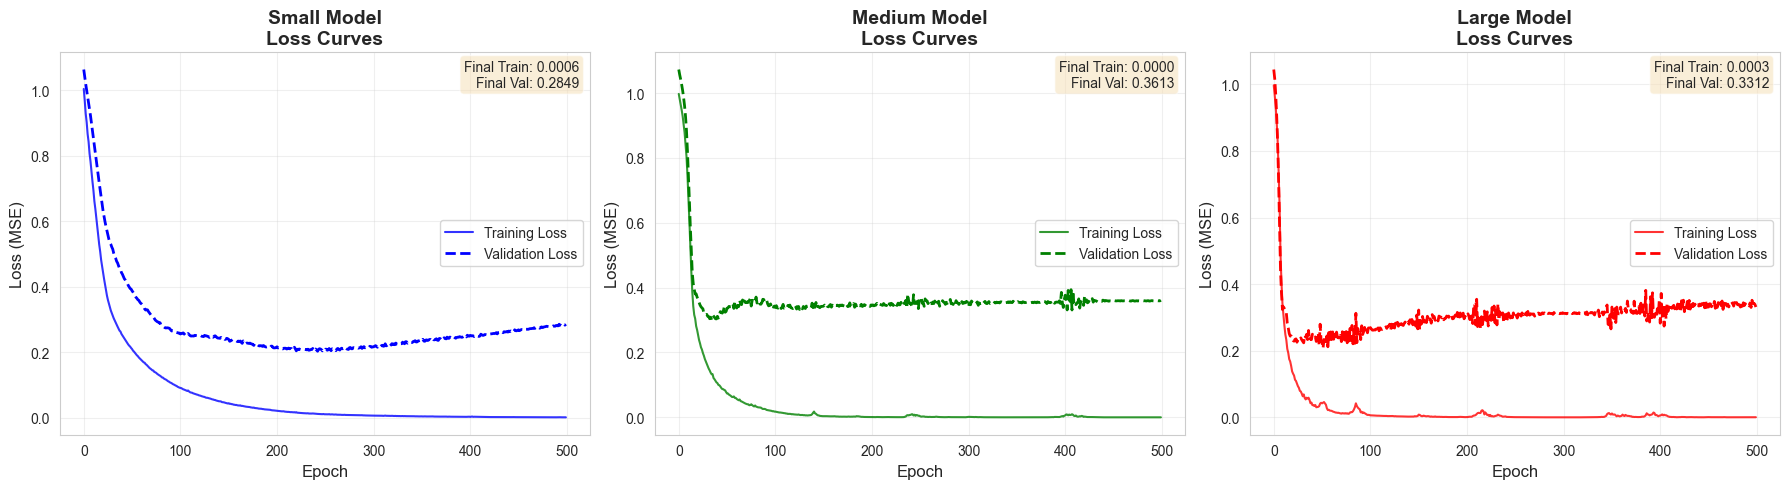

In [395]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

histories = [
    (history_small, 'Small Model', 'blue'),
    (history_medium, 'Medium Model', 'green'),
    (history_large, 'Large Model', 'red')
]

for idx, (history, title, color) in enumerate(histories):
    ax = axes[idx]
    
    ax.plot(history['train_loss'], label='Training Loss', color=color, alpha=0.8)
    ax.plot(history['val_loss'], label='Validation Loss', 
            color=color, linestyle='--', linewidth=2)
    
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Loss (MSE)', fontsize=12)
    ax.set_title(f'{title}\nLoss Curves', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Zeige finale Werte
    final_train_loss = history['train_loss'][-1]
    final_val_loss = history['val_loss'][-1]
    ax.text(0.98, 0.98, 
            f'Final Train: {final_train_loss:.4f}\nFinal Val: {final_val_loss:.4f}',
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=10)

plt.tight_layout()
plt.show()

## 8. Predictions und Fehleranalyse

In [396]:
# Predictions für alle Modelle
models = {
    'Small': model_small,
    'Medium': model_medium,
    'Large': model_large
}

results = []

for name, model in models.items():
    model.eval()
    with torch.no_grad():
        # Predictions (skaliert)
        y_train_pred_scaled = model(X_train_tensor).squeeze().cpu().numpy()
        y_test_pred_scaled = model(X_test_tensor).squeeze().cpu().numpy()
    
    # Zurückskalieren
    y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
    y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
    
    # Metriken berechnen
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Overfitting Gap
    rmse_gap = test_rmse - train_rmse
    rmse_gap_percent = (rmse_gap / train_rmse) * 100
    
    results.append({
        'Model': name,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'RMSE Gap': rmse_gap,
        'Gap %': rmse_gap_percent,
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'Train R²': train_r2,
        'Test R²': test_r2
    })

results_df = pd.DataFrame(results)
print("\n" + "=" * 100)
print("PERFORMANCE VERGLEICH")
print("=" * 100)
print(results_df.to_string(index=False))
print("=" * 100)


PERFORMANCE VERGLEICH
 Model  Train RMSE    Test RMSE     RMSE Gap       Gap %   Train MAE     Test MAE  Train R²  Test R²
 Small 2845.577807 60161.750312 57316.172505 2014.219129 2064.712402 41014.384839  0.999363 0.729862
Medium  707.635996 67747.478455 67039.842459 9473.775059  603.280566 47878.549707  0.999961 0.657445
 Large 2363.505404 64869.656755 62506.151351 2644.637547 1875.340234 52624.331738  0.999560 0.685929


## 9. Visualisierung: Predictions vs. Actual

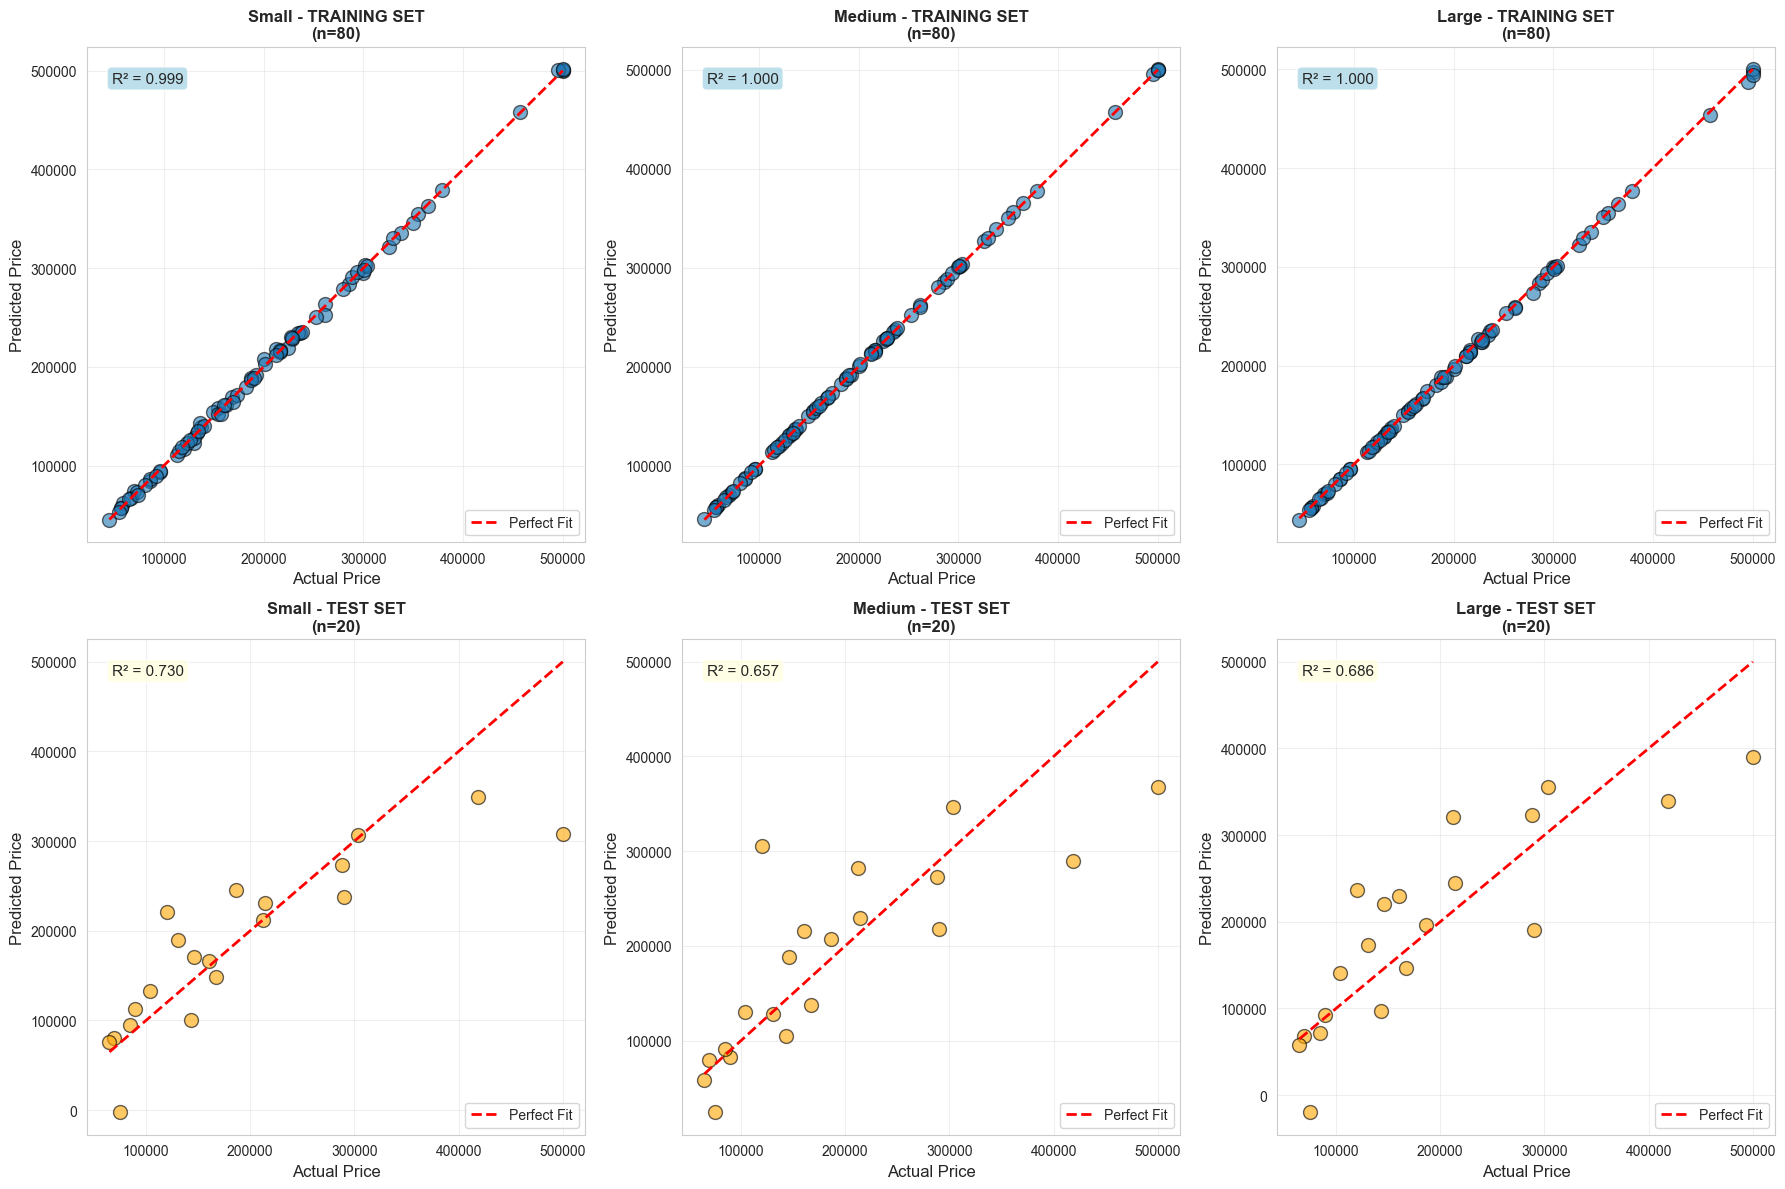

In [397]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for idx, (name, model) in enumerate(models.items()):
    model.eval()
    with torch.no_grad():
        # Predictions
        y_train_pred_scaled = model(X_train_tensor).squeeze().cpu().numpy()
        y_test_pred_scaled = model(X_test_tensor).squeeze().cpu().numpy()
    
    y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
    y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
    
    # Training Set
    ax_train = axes[0, idx]
    ax_train.scatter(y_train, y_train_pred, alpha=0.6, s=100, edgecolors='black')
    ax_train.plot([y_train.min(), y_train.max()], 
                  [y_train.min(), y_train.max()], 
                  'r--', linewidth=2, label='Perfect Fit')
    ax_train.set_xlabel('Actual Price', fontsize=12)
    ax_train.set_ylabel('Predicted Price', fontsize=12)
    ax_train.set_title(f'{name} - TRAINING SET\n(n={len(y_train)})', 
                       fontsize=12, fontweight='bold')
    ax_train.legend()
    ax_train.grid(True, alpha=0.3)
    
    train_r2 = r2_score(y_train, y_train_pred)
    ax_train.text(0.05, 0.95, f'R² = {train_r2:.3f}',
                  transform=ax_train.transAxes,
                  verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
                  fontsize=11)
    
    # Test Set
    ax_test = axes[1, idx]
    ax_test.scatter(y_test, y_test_pred, alpha=0.6, s=100, 
                    edgecolors='black', color='orange')
    ax_test.plot([y_test.min(), y_test.max()], 
                 [y_test.min(), y_test.max()], 
                 'r--', linewidth=2, label='Perfect Fit')
    ax_test.set_xlabel('Actual Price', fontsize=12)
    ax_test.set_ylabel('Predicted Price', fontsize=12)
    ax_test.set_title(f'{name} - TEST SET\n(n={len(y_test)})', 
                      fontsize=12, fontweight='bold')
    ax_test.legend()
    ax_test.grid(True, alpha=0.3)
    
    test_r2 = r2_score(y_test, y_test_pred)
    ax_test.text(0.05, 0.95, f'R² = {test_r2:.3f}',
                 transform=ax_test.transAxes,
                 verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8),
                 fontsize=11)

plt.tight_layout()
plt.show()

## 10. Overfitting/Underfitting Analyse

### Definitionen:

**Overfitting** liegt vor wenn:
- Training Error ist sehr niedrig, aber Test Error ist hoch
- Große Diskrepanz zwischen Training und Test Performance
- Das Modell hat die Trainingsdaten "auswendig gelernt" statt zu generalisieren

**Underfitting** liegt vor wenn:
- Sowohl Training als auch Test Error sind hoch
- Das Modell ist zu einfach, um die Muster in den Daten zu lernen

**Good Fit** liegt vor wenn:
- Training und Test Error sind beide niedrig und ähnlich
- Das Modell generalisiert gut auf neue Daten

In [398]:
def analyze_overfitting(train_rmse, test_rmse, model_name):
    """Analysiere Overfitting/Underfitting basierend auf RMSE"""
    
    gap = test_rmse - train_rmse
    gap_percent = (gap / train_rmse) * 100
    
    print(f"\n{'='*70}")
    print(f"ANALYSE: {model_name}")
    print(f"{'='*70}")
    print(f"Training RMSE:    ${train_rmse:,.2f}")
    print(f"Test RMSE:        ${test_rmse:,.2f}")
    print(f"Differenz:        ${gap:,.2f} ({gap_percent:.1f}%)")
    print(f"{'-'*70}")
    
    # Bewertung
    if gap_percent > 30:
        verdict = "🔴 STARKES OVERFITTING"
        explanation = (
            "Das Modell hat die Trainingsdaten auswendig gelernt, generalisiert\n"
            "aber NICHT gut auf neue Daten. Der Test Error ist deutlich höher\n"
            "als der Training Error.\n\n"
            "Lösungsansätze:\n"
            "  • Mehr Trainingsdaten sammeln\n"
            "  • Modellkomplexität reduzieren (weniger Layer/Neuronen)\n"
            "  • Regularisierung hinzufügen (L1/L2, Dropout)\n"
            "  • Early Stopping verwenden"
        )
    elif gap_percent > 15:
        verdict = "🟡 MODERATES OVERFITTING"
        explanation = (
            "Das Modell zeigt Anzeichen von Overfitting. Es performt auf den\n"
            "Trainingsdaten besser als auf neuen Daten, aber der Unterschied\n"
            "ist noch im akzeptablen Bereich.\n\n"
            "Lösungsansätze:\n"
            "  • Mehr Trainingsdaten sammeln\n"
            "  • Leichte Regularisierung (Dropout, L2)\n"
            "  • Cross-Validation verwenden"
        )
    elif gap_percent > -5:
        verdict = "🟢 GUTER FIT"
        explanation = (
            "Das Modell generalisiert gut! Training und Test Performance sind\n"
            "ähnlich, was darauf hindeutet, dass das Modell die zugrunde liegenden\n"
            "Muster gelernt hat, ohne zu overfitten.\n\n"
            "Das ist das ideale Szenario!"
        )
    else:
        verdict = "🔵 MÖGLICHES UNDERFITTING"
        explanation = (
            "Der Test Error ist niedriger als der Training Error, was ungewöhnlich\n"
            "ist. Dies kann bedeuten:\n"
            "  • Der Test Set ist zufällig einfacher\n"
            "  • Das Modell ist zu einfach (Underfitting)\n"
            "  • Mehr Trainingsdaten oder komplexeres Modell nötig"
        )
    
    # Absoluter Error Check
    median_price = df_small['median_house_value'].median()
    relative_error = (test_rmse / median_price) * 100
    
    print(f"BEWERTUNG: {verdict}")
    print(f"{'-'*70}")
    print(explanation)
    print(f"{'-'*70}")
    print(f"Relativer Fehler: {relative_error:.1f}% vom Median-Preis")
    print(f"{'='*70}\n")

# Analyse für alle Modelle
for _, row in results_df.iterrows():
    analyze_overfitting(row['Train RMSE'], row['Test RMSE'], row['Model'])


ANALYSE: Small
Training RMSE:    $2,845.58
Test RMSE:        $60,161.75
Differenz:        $57,316.17 (2014.2%)
----------------------------------------------------------------------
BEWERTUNG: 🔴 STARKES OVERFITTING
----------------------------------------------------------------------
Das Modell hat die Trainingsdaten auswendig gelernt, generalisiert
aber NICHT gut auf neue Daten. Der Test Error ist deutlich höher
als der Training Error.

Lösungsansätze:
  • Mehr Trainingsdaten sammeln
  • Modellkomplexität reduzieren (weniger Layer/Neuronen)
  • Regularisierung hinzufügen (L1/L2, Dropout)
  • Early Stopping verwenden
----------------------------------------------------------------------
Relativer Fehler: 33.8% vom Median-Preis


ANALYSE: Medium
Training RMSE:    $707.64
Test RMSE:        $67,747.48
Differenz:        $67,039.84 (9473.8%)
----------------------------------------------------------------------
BEWERTUNG: 🔴 STARKES OVERFITTING
---------------------------------------------

## 11. Zusammenfassung: Vergleich der Modelle

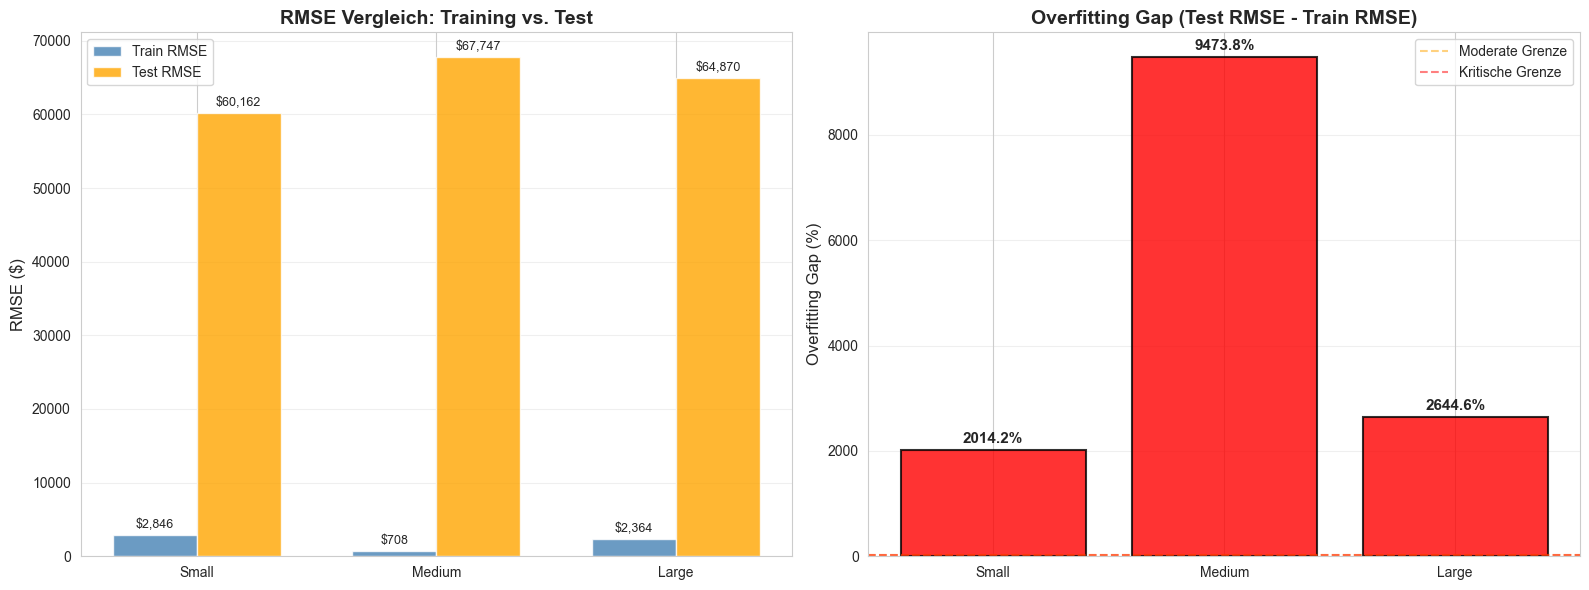


FAZIT
Mit nur 80 Trainingssamples zeigen die Modelle:

Small        -> 🔴 Starkes Overfitting     (Gap: 2014.2%)
Medium       -> 🔴 Starkes Overfitting     (Gap: 9473.8%)
Large        -> 🔴 Starkes Overfitting     (Gap: 2644.6%)

Empfehlung: Für sehr kleine Datensätze sollte ein kleineres Modell
verwendet werden, um Overfitting zu vermeiden!


In [399]:
# Visualisierung der Gaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Balkendiagramm: RMSE Vergleich
x = np.arange(len(results_df))
width = 0.35

bars1 = ax1.bar(x - width/2, results_df['Train RMSE'], width, 
                label='Train RMSE', alpha=0.8, color='steelblue')
bars2 = ax1.bar(x + width/2, results_df['Test RMSE'], width, 
                label='Test RMSE', alpha=0.8, color='orange')

ax1.set_ylabel('RMSE ($)', fontsize=12)
ax1.set_title('RMSE Vergleich: Training vs. Test', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(results_df['Model'])
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Werte auf Balken
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'${height:,.0f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9)

# Overfitting Gap
colors = ['green' if gap < 15 else 'orange' if gap < 30 else 'red' 
          for gap in results_df['Gap %']]

bars = ax2.bar(results_df['Model'], results_df['Gap %'], 
               alpha=0.8, color=colors, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Overfitting Gap (%)', fontsize=12)
ax2.set_title('Overfitting Gap (Test RMSE - Train RMSE)', 
              fontsize=14, fontweight='bold')
ax2.axhline(y=15, color='orange', linestyle='--', alpha=0.5, label='Moderate Grenze')
ax2.axhline(y=30, color='red', linestyle='--', alpha=0.5, label='Kritische Grenze')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Werte auf Balken
for bar in bars:
    height = bar.get_height()
    ax2.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("FAZIT")
print("="*80)
print(f"Mit nur {len(X_train)} Trainingssamples zeigen die Modelle:")
print()
for _, row in results_df.iterrows():
    if row['Gap %'] > 30:
        status = "🔴 Starkes Overfitting"
    elif row['Gap %'] > 15:
        status = "🟡 Moderates Overfitting"
    else:
        status = "🟢 Guter Fit"
    
    print(f"{row['Model']:12s} -> {status:25s} (Gap: {row['Gap %']:6.1f}%)")

print()
print("Empfehlung: Für sehr kleine Datensätze sollte ein kleineres Modell")
print("verwendet werden, um Overfitting zu vermeiden!")
print("="*80)

## 12. Detaillierte Fitting-Analyse pro Datenpunkt

Schauen wir uns an, wie gut einzelne Datenpunkte gefittet werden.

In [400]:
# Zeige die 5 besten und 5 schlechtesten Predictions für jedes Modell
for name, model in models.items():
    print(f"\n{'='*80}")
    print(f"DETAILANALYSE: {name} Model")
    print(f"{'='*80}\n")
    
    model.eval()
    with torch.no_grad():
        y_test_pred_scaled = model(X_test_tensor).squeeze().cpu().numpy()
    
    y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
    
    # Berechne absolute Fehler
    errors = np.abs(y_test.values - y_test_pred)
    
    # DataFrame für Analyse
    analysis_df = pd.DataFrame({
        'Actual': y_test.values,
        'Predicted': y_test_pred,
        'Error': errors,
        'Error %': (errors / y_test.values) * 100
    })
    
    # Top 5 beste Predictions
    print("TOP 5 BESTE PREDICTIONS (niedrigster Fehler):")
    print("-" * 80)
    best = analysis_df.nsmallest(5, 'Error')
    for idx, row in best.iterrows():
        print(f"Actual: ${row['Actual']:>10,.0f} | Predicted: ${row['Predicted']:>10,.0f} | "
              f"Error: ${row['Error']:>10,.0f} ({row['Error %']:>5.1f}%)")
    
    # Top 5 schlechteste Predictions
    print(f"\n{'TOP 5 SCHLECHTESTE PREDICTIONS (höchster Fehler):'}")
    print("-" * 80)
    worst = analysis_df.nlargest(5, 'Error')
    for idx, row in worst.iterrows():
        print(f"Actual: ${row['Actual']:>10,.0f} | Predicted: ${row['Predicted']:>10,.0f} | "
              f"Error: ${row['Error']:>10,.0f} ({row['Error %']:>5.1f}%)")
    
    print(f"\nDurchschnittlicher Fehler: ${errors.mean():,.0f} ({(errors / y_test.values).mean() * 100:.1f}%)")


DETAILANALYSE: Small Model

TOP 5 BESTE PREDICTIONS (niedrigster Fehler):
--------------------------------------------------------------------------------
Actual: $   211,900 | Predicted: $   212,411 | Error: $       511 (  0.2%)
Actual: $   303,900 | Predicted: $   306,692 | Error: $     2,792 (  0.9%)
Actual: $   160,200 | Predicted: $   166,328 | Error: $     6,128 (  3.8%)
Actual: $    85,100 | Predicted: $    95,412 | Error: $    10,312 ( 12.1%)
Actual: $    64,900 | Predicted: $    75,638 | Error: $    10,738 ( 16.5%)

TOP 5 SCHLECHTESTE PREDICTIONS (höchster Fehler):
--------------------------------------------------------------------------------
Actual: $   500,001 | Predicted: $   308,046 | Error: $   191,955 ( 38.4%)
Actual: $   120,500 | Predicted: $   220,432 | Error: $    99,932 ( 82.9%)
Actual: $    75,000 | Predicted: $    -2,345 | Error: $    77,345 (103.1%)
Actual: $   418,800 | Predicted: $   349,550 | Error: $    69,250 ( 16.5%)
Actual: $   186,200 | Predicted: $   